<a href="https://colab.research.google.com/github/TiGaI/HousingPriceKaggleProject3/blob/xiangwei/ames_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
### import necessary packages
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib as plt
from matplotlib import pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline

#Add max display column
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

**Jupyterhub sux**


---



In [2]:
### load training and test data
train_df = pd.read_csv('https://raw.githubusercontent.com/TiGaI/HousingPriceKaggleProject3/master/data/train.csv')
test_df = pd.read_csv('https://raw.githubusercontent.com/TiGaI/HousingPriceKaggleProject3/master/data/test.csv')

### view train dataset
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8edad33240>,
      dtype=object)

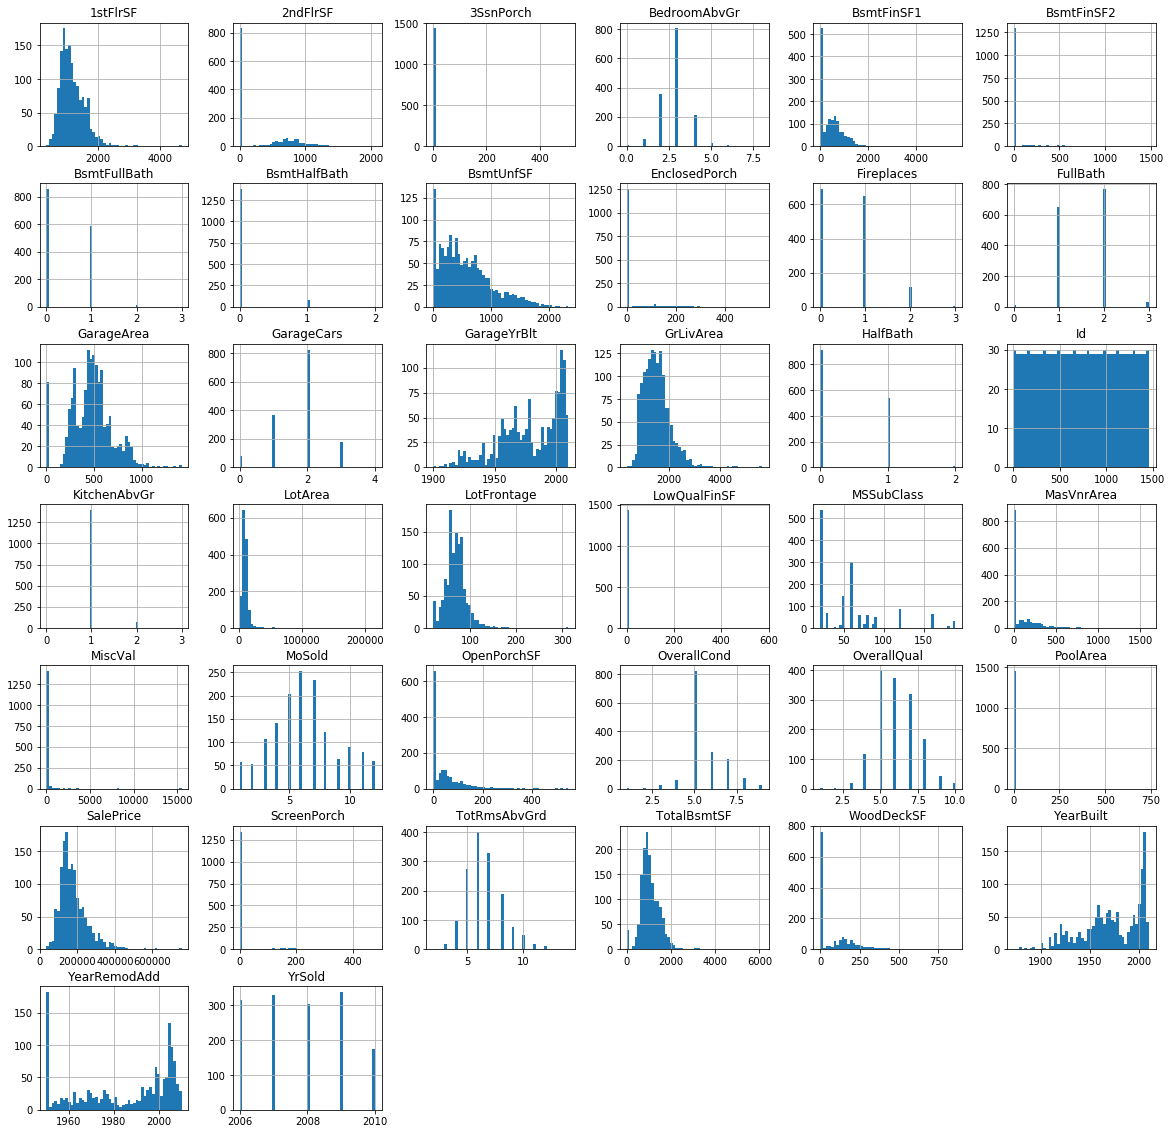

In [0]:
### Check the distribution of all the numeric variables
train_df.hist(bins=50, figsize=(20,20))

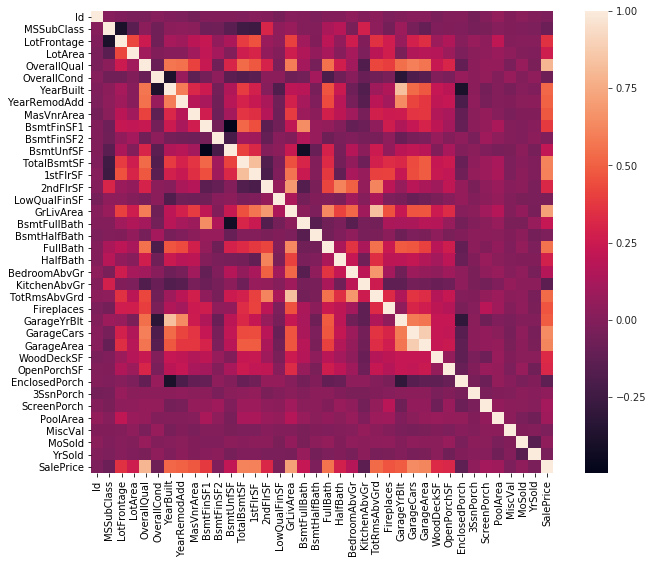

In [0]:
#### look at the correlation heatmap
fig, ax = plt.subplots(figsize=(11.5,8.5))
sns.set_style("white")
sns.heatmap(train_df.corr(),square=True)

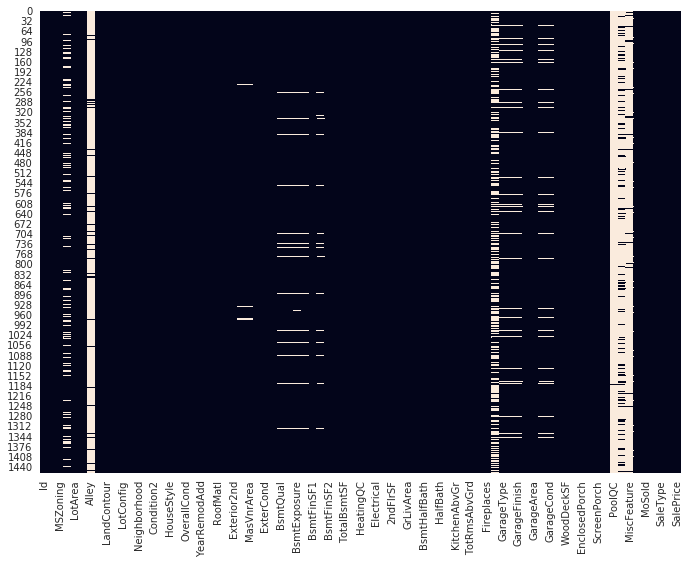

In [0]:
#### missing values
fig, ax = plt.subplots(figsize=(11.5,8.5))
sns.set_style("white")
sns.heatmap(train_df.isnull(), cbar=False)

In [0]:
#### study the missing values
train_missing = train_df.isna()
train_num_missing = train_missing.sum().to_frame()
#train_num_missing.sort_values(ascending = False)
train_num_missing['Percentage'] = train_num_missing[0]/1460
train_num_missing.columns = ['Missing Value', 'Percentage']
train_num_missing = train_num_missing.sort_values('Percentage', ascending = False)
train_num_missing[train_num_missing['Missing Value'] > 0]  ### 19


,Missing Value,Percentage
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
GarageCond,81,0.055479
GarageType,81,0.055479
GarageFinish,81,0.055479


In [3]:
train_full = train_df.drop('Id', axis = 1)
print(train_full.columns)

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [0]:
### Treating the missing values
## 'LotFrontage', 'MasVnrArea', 'PoolArea'
#num columns we filling in missing value with zero
train_full['LotFrontage'].fillna(0, inplace=True)  ## fill in the NAs of LotFrontage with 0
train_full['MasVnrArea'].fillna(0, inplace=True)  ## fill in the NAs of MasVnrArea with 0
train_full['Pool'] = train_full['PoolArea'].apply(lambda x: 1 if x > 0 else 0)  ## create a new variable indicating whether the house has a pool or not

## 'MasVnrType', 'PoolQC', 'GarageCond'
#cat columns
train_full['MasVnrType'].fillna('None', inplace=True)  ## fill in the NAs of MasVnrType with None
train_full['PoolQC'].fillna('None',inplace=True)  ## fill in the NAs of PoolQC with None

## Hash 'PoolQC'
PoolReplacement = {
   'PoolQC': {
      'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5
   }
}

# replace the PoolQC
train_full.replace(PoolReplacement, inplace=True)

## Hash 'GarageQual', 'GarageCond', 'GarageFinish'
garabgeReplacement = {
   'GarageQual': {
      np.nan:0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5
   },
    'GarageCond': {
      np.nan:0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5
   },
    'GarageFinish': {
      np.nan:0, 'Unf': 1, 'RFn': 2, 'Fin': 3
   }
}

# replace 'GarageQual', 'GarageCond', 'GarageFinish'
train_full = train_full.replace(garabgeReplacement, inplace=False)

# create 'GarageQuality' that takes the average of 'GarageQual' and 'GarageCond'
train_full["GarageQuality"] = (train_full["GarageQual"] + train_full["GarageCond"])/2

# fill in the NAs of GarageYrBlt with YearBuilt
train_full['GarageYrBlt'].fillna(train_full['YearBuilt'], inplace=True)

# fill in the NAs of 'GarageType' with 'None'
train_full['GarageType'].fillna("None", inplace=True)

## Hash 'BsmtFinType1', 'BsmtFinType2', 'BsmtExposure', 'BsmtCond', 'BsmtQual'
BsmtReplacement = {
   'BsmtFinType1': {
      np.nan:0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6
   },
    'BsmtFinType2': {
      np.nan:0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6
   },
    'BsmtExposure': {
        np.nan:0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4
    },
    'BsmtCond': {
        np.nan:0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5
    },
    'BsmtQual': {
        np.nan:0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5
    },
}

# replace 'BsmtFinType1', 'BsmtFinType2', 'BsmtExposure', 'BsmtCond', 'BsmtQual'
train_full = train_full.replace(BsmtReplacement)

# convert the type of 'BsmtCond' to int64
train_full["BsmtCond"] = train_full["BsmtCond"].astype(np.int64)

## Hash FireplaceQu
FirePlaceReplacement ={
    'FireplaceQu': {
        np.nan: 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5
    }
}

# replace 'FireplaceQu'
train_full = train_full.replace(FirePlaceReplacement)


## Fill the NAs of 'Electrical' with 'SBrkr'
train_full['Electrical'].fillna('SBrkr', inplace=True)

## Fill the NAs of 'Fence' with 'None'
train_full['Fence'].fillna('None', inplace=True)

## Alley? Drop Alley?
train_full = train_full.drop(['Alley'], axis=1)

## Fill the NAs of 'MiscFeature' with None
train_full['MiscFeature'].fillna('None', inplace=True)


In [0]:
#### study the missing values
train_missing = train_full.isna()
train_num_missing = train_missing.sum().to_frame()
#train_num_missing.sort_values(ascending = False)
train_num_missing['Percentage'] = train_num_missing[0]/1460
train_num_missing.columns = ['Missing Value', 'Percentage']
train_num_missing = train_num_missing.sort_values('Percentage', ascending = False)
train_num_missing  ### 19

,Missing Value,Percentage
MSSubClass,0,0.0
1stFlrSF,0,0.0
GarageCars,0,0.0
GarageFinish,0,0.0
GarageYrBlt,0,0.0
GarageType,0,0.0
FireplaceQu,0,0.0
Fireplaces,0,0.0
Functional,0,0.0
TotRmsAbvGrd,0,0.0


In [0]:
### replace the conditions and qualities with numbers: 'ExterQual', 'ExterCond, 'HeatingQC', 'KitchenQual', 'CentralAir', 'LotShape'
CondReplacement = {
   'ExterQual': {
      'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5
   },
    'ExterCond': {
      'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5
   },
    'HeatingQC': {
        'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5
    },
    'KitchenQual': {
        'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5
    },
    'CentralAir': {
        'N': 0, 'Y': 1
    },
    'LotShape': {
        'IR3': 0, 'IR2': 1, 'IR1': 2, 'Reg': 3
    },
    'Functional': {
        'Typ': 5, 'Min1': 4, 'Min2': 4, 'Mod': 3, 'Maj1': 2, 'Maj2': 2, 'Sev': 1, 'Sal': 0
    }
}

# replace those variables
train_full = train_full.replace(CondReplacement)


***Feature Engineereing ***

In [0]:
### find the age of the house by subtracting YrSold and YearRemodAdd
train_full['HouseAge'] = train_full['YrSold']-train_full['YearRemodAdd']

### find the age of the garage by subtracting YrSold and GarageYrBlt
train_full['GarageAge'] = train_full['YrSold'] - train_full['GarageYrBlt']   ### this has 0.6 correlation with HouseAge

### create a binary remodel variable to denote whether it has been remodeled or not
train_full['Remodel'] = (
    np.where(
        train_full['YearBuilt'] == train_full['YrSold'], 
        0, 
        1
        ))

### create a new variable TotolBath to sum up the num of bathrooms in the house
train_full['TotalBath'] = train_full['FullBath'] + 0.5 * train_full['HalfBath'] + train_full['BsmtFullBath'] + 0.5 * train_full['BsmtHalfBath']

### Take care of PorchSF 
train_full['TotalPorchSF'] = train_full['OpenPorchSF'] + train_full['EnclosedPorch'] + train_full['3SsnPorch'] + train_full['ScreenPorch']

## replace the MSZoning by Mean and median
MSZoninglReplacement = {
   'MSZoning': {
      'C (all)': 0, 'RM': 1, 'RH': 2, 'RL': 3, 'FV': 4
   }
}

# replace the MSZoning
train_full.replace(MSZoninglReplacement, inplace=True)

#a=train_full.groupby(['Condition1']).agg({'SalePrice':['mean', 'median']}).reset_index()
#b=train_full.groupby(['Condition2']).agg({'SalePrice':['mean', 'median']}).reset_index()
#print(a)
#print(b)

## Take care of Condition1 and Condition 2
train_full['Condition2Renew'] = np.where(train_full['Condition1'] == train_full['Condition2'], 0, 1)
train_full = train_full.drop(['Condition2'], axis=1)


In [0]:
#### collapse 'MSSubClass', 'HouseStyle' into 'Floor', 'Finished', 'PUD', 'SFoyer', 'SLvl', 
## Create 'PUB' column:
def PUDCol(x):
  if x['MSSubClass'] in [120,150,160,180]:
    return 1
  else:
    return 0
  
train_full['PUD'] = train_full.apply (lambda row: PUDCol(row), axis=1)

In [0]:
## collapse 'HouseStyle' into 'SFoyer', 'Floor', 'Finish', 'Slvl'
tempstyle = train_full['HouseStyle'].str.split('(\d*\.\d+|\d+)([A-Za-z]+)', expand=True)
tempstyle.rename(columns={0:'SFoyer',1:'Floor', 2:'Finish',3:'Slvl'}, inplace=True)
tempstyle['Slvl'] = np.where(tempstyle['SFoyer']=="Slvl", 1, 0)
tempstyle['SFoyer'] = np.where(tempstyle['SFoyer']=="SFoyer", 1, 0)
tempstyle['Finish'] = np.where(tempstyle['Finish']=="Story", 1, tempstyle['Finish'])
tempstyle['Finish'] = np.where(tempstyle['Finish']=="Fin", 1, tempstyle['Finish'])
tempstyle['Finish'] = np.where(tempstyle['Finish']=="Unf", 0, tempstyle['Finish'])
#tempstyle
train_full1 = pd.concat([train_full, tempstyle], axis = 1)

In [0]:
## fill in the blanks for Floor
def FloorCol(df):
  if df['HouseStyle'] == 'SFoyer':
    if df['MSSubClass'] == 85:
      return 1.5
    if df['MSSubClass'] == 90:
      return 1.5
    if df['MSSubClass'] == 180:
      return 2.5
    if df['MSSubClass'] == 120:
      return 1
  elif df['HouseStyle'] == 'SLvl':
    if df['MSSubClass'] == 80:
      return 1.5
    if df['MSSubClass'] == 180:
      return 2.5
    if df['MSSubClass'] == 190:
      return 2.5
    if df['MSSubClass'] == 20:
      return 1
    if df['MSSubClass'] == 90:
      return 2
    if df['MSSubClass'] == 60:
      return 2
  else:
    return df['Floor']

train_full1['Floor'] = train_full1.apply (lambda row: FloorCol(row), axis=1)
train_full1['Floor'] = train_full1['Floor'].astype(np.float16)

In [0]:
### fill in the blanks for Finish
train_full1['Finish'].fillna(1, inplace=True)

In [11]:
### Fill in the exterior
train_full1['exterior1stC'], _ = pd.factorize(train_full1['Exterior1st'], sort=True)
train_full1['exterior2ndC'], _ = pd.factorize(train_full1['Exterior2nd'], sort=True)
print(train_full1['exterior2ndC'].corr(train_full1['exterior1stC']))

train_full2 = train_full1.groupby('exterior1stC').agg({'SalePrice': 'mean'})
print(train_full2)
train_full2 = train_full2.reset_index()
train_full2 = pd.qcut(train_full2['SalePrice'], 4, labels=[0.25,0.5,0.75,1])
train_full1['ExteriorBin'] = train_full1['exterior1stC'].apply(lambda x: train_full2[x])
train_full1['ExteriorBin'].value_counts()

0.8541629837325749
                  SalePrice
exterior1stC               
0             107385.550000
1             100000.000000
2              71000.000000
3             194573.000000
4             105000.000000
5             231690.655738
6             163077.450450
7             262000.000000
8             149422.177273
9             175942.379630
10            258500.000000
11            162990.000000
12            213732.900971
13            149841.645631
14            150655.076923


1.00    579
0.50    477
0.75    380
0.25     24
Name: ExteriorBin, dtype: int64

In [0]:
#### study the missing values
train_missing = train_full1.isna()
train_num_missing = train_missing.sum().to_frame()
#train_num_missing.sort_values(ascending = False)
train_num_missing['Percentage'] = train_num_missing[0]/1460
train_num_missing.columns = ['Missing Value', 'Percentage']
train_num_missing = train_num_missing.sort_values('Percentage', ascending = False)
train_num_missing  ### 19

,Missing Value,Percentage
MSSubClass,0,0.0
GarageArea,0,0.0
PoolArea,0,0.0
ScreenPorch,0,0.0
3SsnPorch,0,0.0
EnclosedPorch,0,0.0
OpenPorchSF,0,0.0
WoodDeckSF,0,0.0
PavedDrive,0,0.0
GarageCond,0,0.0


In [12]:
train_full1.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces',
       'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive',
       'WoodDeckSF', 'OpenPorchSF

In [15]:
train_full1.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,...,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Pool,GarageQuality,HouseAge,GarageAge,Remodel,TotalBath,TotalPorchSF,Condition2Renew,PUD,SFoyer,Floor,Finish,Slvl,exterior1stC,exterior2ndC,ExteriorBin
0,60,3,65.0,8450,Pave,3,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,4,3,PConc,4,3,1,6,706,1,0,150,856,GasA,5,1,SBrkr,...,0,Attchd,2003.0,2,2,548,3,3,Y,0,61,0,0,0,0,0,None,None,0,2,2008,WD,Normal,208500,0,3.0,5,5.0,1,3.5,61,0,0,0,2.0,1,0,12,13,1.0
1,20,3,80.0,9600,Pave,3,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,3,3,CBlock,4,3,4,5,978,1,0,284,1262,GasA,5,1,SBrkr,...,3,Attchd,1976.0,2,2,460,3,3,Y,298,0,0,0,0,0,0,None,None,0,5,2007,WD,Normal,181500,0,3.0,31,31.0,1,2.5,0,1,0,0,1.0,1,0,8,8,0.5
2,60,3,68.0,11250,Pave,2,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,4,3,PConc,4,3,2,6,486,1,0,434,920,GasA,5,1,SBrkr,...,3,Attchd,2001.0,2,2,608,3,3,Y,0,42,0,0,0,0,0,None,None,0,9,2008,WD,Normal,223500,0,3.0,6,7.0,1,3.5,42,0,0,0,2.0,1,0,12,13,1.0
3,70,3,60.0,9550,Pave,2,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,3,3,BrkTil,3,4,1,5,216,1,0,540,756,GasA,4,1,SBrkr,...,4,Detchd,1998.0,1,3,642,3,3,Y,0,35,272,0,0,0,0,None,None,0,2,2006,WD,Abnorml,140000,0,3.0,36,8.0,1,2.0,307,0,0,0,2.0,1,0,13,15,0.5
4,60,3,84.0,14260,Pave,2,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,4,3,PConc,4,3,3,6,655,1,0,490,1145,GasA,5,1,SBrkr,...,3,Attchd,2000.0,2,3,836,3,3,Y,192,84,0,0,0,0,0,None,None,0,12,2008,WD,Normal,250000,0,3.0,8,8.0,1,3.5,84,0,0,0,2.0,1,0,12,13,1.0


In [0]:
train_full1.corr()['SalePrice'].sort_values(ascending=False)[]

HeatingQC        0.427649
BsmtFinSF1       0.386420
BsmtExposure     0.374696
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
BsmtFinType1     0.304908
HalfBath         0.284108
GarageQual       0.273839
GarageQuality    0.271310
LotArea          0.263843
GarageCond       0.263191
CentralAir       0.251328
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BsmtCond         0.212607
LotFrontage      0.209624
BedroomAbvGr     0.168213
Floor            0.139712
PoolQC           0.111696
ScreenPorch      0.111447
Pool             0.093708
PoolArea         0.092404
Finish           0.083104
MoSold           0.046432
3SsnPorch        0.044584
ExterCond        0.018899
BsmtFinType2    -0.005323
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
LowQualFinSF    -0.025606
YrSold          -0.028923
PUD             -0.047539
OverallCond     -0.077856
MSSubClass      -0.084284
SFoyer          -0.093090
EnclosedPorch   -0.128578
KitchenAbvGr

In [14]:
#split numerical and catergorical values
numTrain = train_full1.loc[:, train_full1.dtypes != 'object']
catTrain = train_full1.loc[:, train_full1.dtypes == 'object']
print(catTrain.columns)


Index(['Street', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation',
       'Heating', 'Electrical', 'Functional', 'GarageType', 'PavedDrive',
       'Fence', 'MiscFeature', 'SaleType', 'SaleCondition'],
      dtype='object')


In [0]:
# fig, ax = plt.subplots(figsize=(11.5,8.5))
# a=train_full.groupby(['Neighborhood']).agg({'SalePrice':'mean'}).reset_index()
# a.sort_values(by=['SalePrice'],inplace=True)
# plt.xticks(rotation=45)
# a.boxplot(column='Neighborhood',by='SalePrice')
# # b.set_xticklabels(b.get_xticklabels(),rotation=45)
# a.describe()

,MSSubClass,LotFrontage,LotArea,LotShape,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,MiscVal,MoSold,YrSold,SalePrice,Pool,GarageQuality,Age,Remodel
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.00000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,57.623288,10516.828082,2.591781,6.099315,5.575342,1971.267808,1984.865753,103.117123,3.39589,3.083562,3.489041,2.934932,1.630137,3.545890,443.639726,1.247260,46.549315,567.240411,1057.429452,4.145205,0.934932,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,3.511644,6.517808,0.613014,1.825342,1976.507534,1.715753,1.767123,472.980137,2.810274,2.808904,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,0.017808,43.489041,6.321918,2007.815753,180921.195890,0.004795,2.809589,22.950000,0.956164
std,42.300571,34.664304,9981.264932,0.582296,1.382997,1.112799,30.202904,20.645407,180.731373,0.57428,0.351054,0.876478,0.552159,1.067391,2.107776,456.098091,0.892332,161.319273,441.866955,438.705324,0.959501,0.246731,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,0.663760,1.625393,0.644666,1.810877,26.306739,0.892831,0.747315,213.804841,0.722898,0.719685,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,0.268952,496.123024,2.703626,1.328095,79442.502883,0.069100,0.713891,20.640653,0.204799
min,20.000000,0.000000,1300.000000,0.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,2.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,1872.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000,0.000000,0.000000,-1.000000,0.000000
25%,20.000000,42.000000,7553.500000,2.000000,5.000000,5.000000,1954.000000,1967.000000,0.000000,3.00000,3.000000,3.000000,3.000000,1.000000,1.000000,0.000000,1.000000,0.000000,223.000000,795.750000,3.000000,1.000000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,3.000000,5.000000,0.000000,0.000000,1959.000000,1.000000,1.000000,334.500000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000,0.000000,3.000000,4.000000,1.000000
50%,50.000000,63.000000,9478.500000,3.000000,6.000000,5.000000,1973.000000,1994.000000,0.000000,3.00000,3.000000,4.000000,3.000000,1.000000,4.000000,383.500000,1.000000,0.000000,477.500000,991.500000,5.000000,1.000000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,3.000000,6.000000,1.000000,2.000000,1978.000000,2.000000,2.000000,480.000000,3.000000,3.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,

,SalePrice
count,15.000000
mean,166387.389108
std,57697.237310
min,71000.000000
25%,128403.863636
50%,162990.000000
75%,204152.950485
max,262000.000000


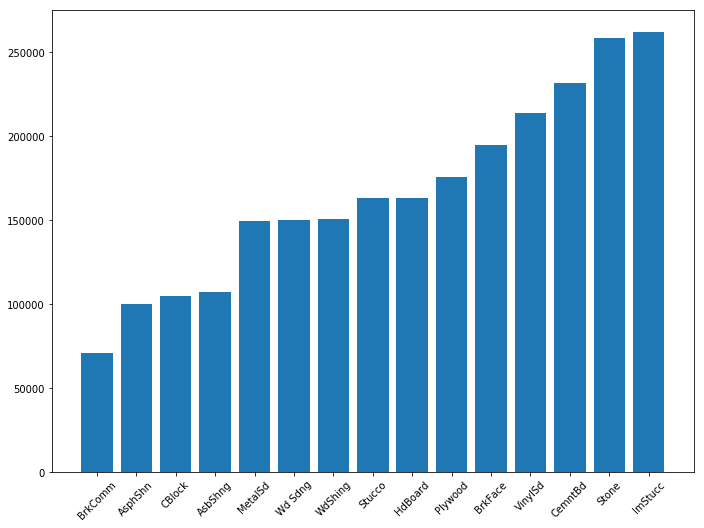

In [0]:
fig, ax = plt.subplots(figsize=(11.5,8.5))
a=train_full.groupby(['Exterior1st']).agg({'SalePrice':'mean'}).reset_index()
a.sort_values(by=['SalePrice'],inplace=True)
plt.xticks(rotation=45)
plt.bar(a['Exterior1st'],a['SalePrice'])
# b.set_xticklabels(b.get_xticklabels(),rotation=45)
a.describe()

,SalePrice
count,16.000000
mean,175288.201376
std,55551.545319
min,105000.000000
25%,145789.549492
50%,159776.873684
75%,200471.615079
max,319000.000000


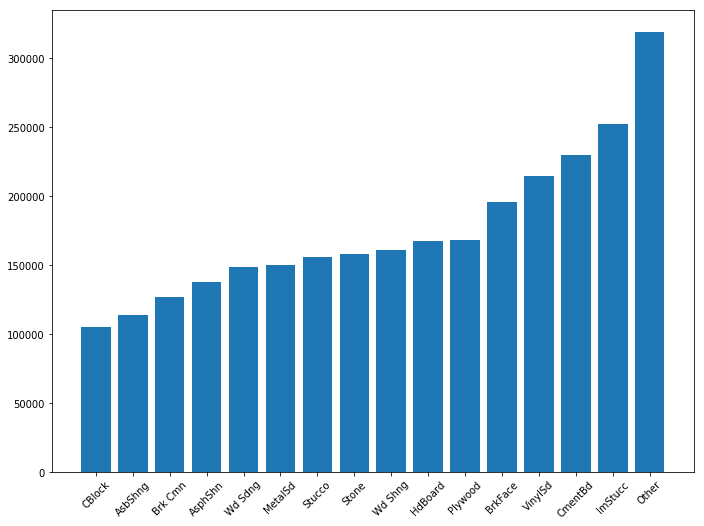

In [0]:
fig, ax = plt.subplots(figsize=(11.5,8.5))
a=train_full.groupby(['Exterior2nd']).agg({'SalePrice':'mean'}).reset_index()
a.sort_values(by=['SalePrice'],inplace=True)
plt.xticks(rotation=45)
plt.bar(a['Exterior2nd'],a['SalePrice'])
# b.set_xticklabels(b.get_xticklabels(),rotation=45)
a.describe()

,SalePrice
count,7.000000
mean,144456.679168
std,31265.493355
min,85800.000000
25%,136620.323529
50%,146385.483871
75%,161170.738095
max,183429.147059


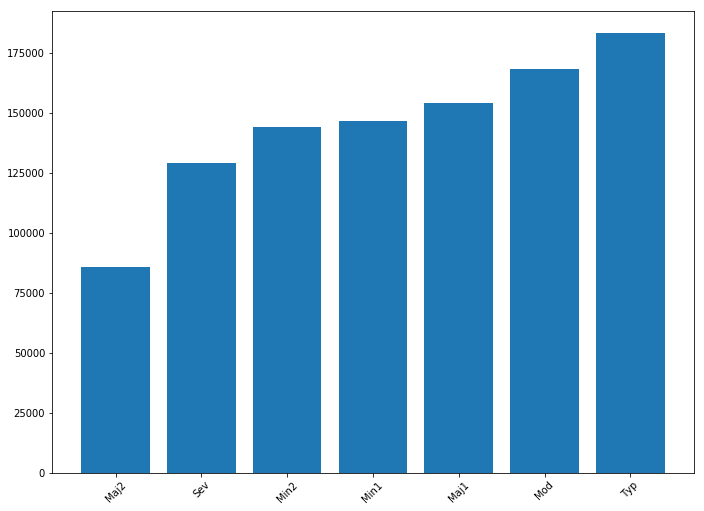

In [0]:
fig, ax = plt.subplots(figsize=(11.5,8.5))
a=train_full1.groupby(['Functional']).agg({'SalePrice':'mean'}).reset_index()
a.sort_values(by=['SalePrice'],inplace=True)
plt.xticks(rotation=45)
plt.bar(a['Functional'],a['SalePrice'])
# b.set_xticklabels(b.get_xticklabels(),rotation=45)
a.describe()

In [0]:
train_full1['Functional'].value_counts()

Typ     1360
Min2      34
Min1      31
Mod       15
Maj1      14
Maj2       5
Sev        1
Name: Functional, dtype: int64

In [0]:
for var in catTrain:
    print(var, ' contains ', len(catTrain[var].unique()), ' labels')

MSZoning  contains  5  labels
Street  contains  2  labels
LotShape  contains  4  labels
LandContour  contains  4  labels
Utilities  contains  2  labels
LotConfig  contains  5  labels
LandSlope  contains  3  labels
Neighborhood  contains  25  labels
Condition1  contains  9  labels
Condition2  contains  8  labels
BldgType  contains  5  labels
HouseStyle  contains  8  labels
RoofStyle  contains  6  labels
RoofMatl  contains  8  labels
Exterior1st  contains  15  labels
Exterior2nd  contains  16  labels
MasVnrType  contains  4  labels
ExterQual  contains  4  labels
ExterCond  contains  5  labels
Foundation  contains  6  labels
Heating  contains  6  labels
HeatingQC  contains  5  labels
CentralAir  contains  2  labels
Electrical  contains  5  labels
KitchenQual  contains  4  labels
Functional  contains  7  labels
GarageType  contains  7  labels
PavedDrive  contains  3  labels
Fence  contains  5  labels
MiscFeature  contains  5  labels
SaleType  contains  9  labels
SaleCondition  contains  6 

In [0]:
### Variables to drop
#train_full1.drop(['HouseStyle', 'MSSubClass', 'YearBuilt', 'YearRemodAdd', 'OpenPorchSF', 'EnclosedPorch', 'X3SsnPorch', 'ScreenPorch', 'Condition2'], axis=1)


numpy.int64

In [0]:
### Variables to dummify
